# Preeclampsia Classifier

## Package Installation

In [1]:
# !pip install -U skorch
# !pip install sklearn
# !pip install -U seaborn
# ! pip install -U numpy
# !pip install matplotlib

## Libraries

In [2]:
# loading basic libraries
import time
import random
import ntpath
import glob
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# loading torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

# loading torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.models.vision_transformer import VisionTransformer

# loading skorch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler, Checkpoint, Freezer, EarlyStopping, EpochScoring, Callback

# loading sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

# Experiment Name

In [3]:
NAME_OF_EXPERIMENT = "Convolutional Neural Network (Fetal Side)"

# Dataset Class

In [4]:
# Defining the dataset
class Dataset(Dataset):
    """Defines the dataset"""
    def __init__(self, X, y, transform=None):
        self.X = X.reset_index().drop('index', axis=1).path
        self.y = torch.tensor(y.reset_index().drop('index', axis=1).label.astype('category').cat.codes, dtype=torch.long)
        self.transform = transform

        assert len(self.X) == len(self.y), f'X and y have different lengths -> {len(self.X)} != {len(self.y)} '

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        # print(f"Opening image: {img_path}")
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        label = self.y[idx]
        return (img, label)
  

    def show_img(self, idx):
        '''Plot image'''
        img, label = self.__getitem__(idx)
        if img is not None:
            img = img.numpy().transpose((1, 2, 0))
            plt.figure(figsize=(16, 8))
            plt.axis('off')
            plt.imshow(img)
            plt.title(label)
            plt.pause(0.001)

# Transformations 

### TODO: Define the transformations needed for the Convolutional Neural Network

In [5]:
# TODO: Define the transformations needed for the Convolutional Neural Network

# Defining the transformation for the training, validation and test sets
class TRANSFORMATIONS:
    """Contains all the necessary transformations for the training, validation and test sets"""
    TRAIN_TRANSFORMS = transforms.Compose([
        #transforms.RandomResizedCrop(224),  # Random resized cropping
        transforms.RandomHorizontalFlip(),  # Random horizontal flipping
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Color jitter
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),  # Gaussian blur      
        transforms.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),  # Random perspective 
        
        # Rotate the image by given angle.
        transforms.RandomRotation(5),
        # Crop the given PIL Image to a given size
        transforms.Resize((232,232)),
        transforms.CenterCrop(224),
        # Horizontally flip the given PIL Image randomly with a given probability.
        transforms.RandomHorizontalFlip(p = 0.2),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])

    VAL_TRANSFORMS = transforms.Compose([
        #Rotate the image by given angle.
        # transforms.RandomRotation(5),    
        #Horizontally flip the given PIL Image randomly with a given probability.
        # transforms.RandomHorizontalFlip(p = 0.2),
        
        # Resize the image to a fixed size
        # transforms.Resize(256),  
        # Crop the center of the image
        # transforms.CenterCrop(224),    
        
        #Crop the given PIL Image to random size and aspect ratio.
        transforms.Resize((232,232)),
        transforms.CenterCrop(224),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])

    TEST_TRANSFORMS = transforms.Compose([
        #Rotate the image by given angle.
        # transforms.RandomRotation(5),    
        #Horizontally flip the given PIL Image randomly with a given probability.
        # transforms.RandomHorizontalFlip(p = 0.2),
        
        # Resize the image to a fixed size
        # transforms.Resize(256),  
        # Crop the center of the image
        # transforms.CenterCrop(224),  
             
        #Crop the given PIL Image to random size and aspect ratio.
        transforms.Resize((232,232)),
        transforms.CenterCrop(224),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])

### TODO: Implement other techniques used in the previous work you did in the next cell

In [6]:
# TODO: Implementations specific to the previous analysis you did

# Neural Network Configuration
added callbacks found https://github.com/skorch-dev/skorch/blob/master/notebooks/Transfer_Learning.ipynb

In [7]:
# Setup the neural network configuration
class NEURAL_NETWORK_CONFIG:
    """Stores all neccesary configurations for the neural network""" 

    # basics
    SEED = 4040
    TEST_SIZE = 0.1
    NUMBER_OF_FOLDS = 5
    
    # performance metrics
    ROC_AUC = EpochScoring(scoring='roc_auc', name='valid_roc_auc', lower_is_better=False)
    RECALL = EpochScoring(scoring='recall', name='valid_recall', lower_is_better=False)
    PRECISION = EpochScoring(scoring='precision', name='valid_precision', lower_is_better=False)
    F1 = EpochScoring(scoring='f1', name='valid_f1', lower_is_better=False)
    EARLY_STOPPING = EarlyStopping(monitor='valid_loss', patience=7, lower_is_better=True)
    
    ROC_AUC_AVERAGE_PARAMETER = 'weighted'
    RECALL_AVERAGE_PARAMETER = 'weighted'
    PRECISION_AVERAGE_PARAMETER = 'weighted'
    F1_AVERAGE_PARAMETER = 'weighted'
     
    # model
    CRITERION = nn.CrossEntropyLoss 
    OPTIMIZER = optim.Adam
    MOMENTUM = 0.9
    LR = 0.001 
    BATCH_SIZE = 64
    EPOCHS = 100
    OUTPUT_FEATURES = 2 
    
    # callbacks
    LRSCHEDULER = LRScheduler(policy='StepLR', step_size=5, gamma=0.75)
    CHECKPOINT = Checkpoint(f_params='best_model.pt', monitor='valid_acc_best')
    FREEZER = Freezer(lambda x: not x.startswith('model.fc'))
    CALLBACKS = [LRSCHEDULER, CHECKPOINT, FREEZER, ROC_AUC, RECALL, PRECISION, F1, EARLY_STOPPING] 
    
    # device
    DEVICE = torch.device("mps")#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('You are using ->', DEVICE)

You are using -> mps


# Reproducibility

In [8]:
# Make results reproducible
def seed_for_reproducibility(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_for_reproducibility(NEURAL_NETWORK_CONFIG.SEED)

# Neural Network Architecture 

### TODO: (Implement the Convolutional Neural Network Architecture Below)

In [9]:
#TODO: Implement the Convolutional Neural Network Architecture Below

# Defining the neural network architecture 
class Model(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        # load pre-trained model
        model = models.resnet50(pretrained=True)
        # Replace the last fully connected layer
        n_inputs = model.fc.in_features
        model.fc = nn.Linear(n_inputs, output_features)
        
        self.model = model


    def forward(self, x):
        return self.model(x)
    
    def get_trainable_params(self):
        return self.model.fc.parameters()

# Reading Dataset

In [10]:
# reading the training data
data = pd.read_csv("./fetal_data_csv/placenta_training_data.csv")

# reading the test data
external_test_data = pd.read_csv("./fetal_data_csv/placenta_external_test_data.csv")

data

,path,label
0,./fetal_data\Healthy\8972F.JPG,0
1,./fetal_data\Preeclampsia\9867F.jpg,1
2,./fetal_data\Healthy\11632F.jpg,0
3,./fetal_data\Healthy\9094F.JPG,0
4,./fetal_data\Preeclampsia\5006F.jpg,1
...,...,...
340,./fetal_data\Preeclampsia\8827F.JPG,1
341,./fetal_data\Healthy\9066F.JPG,0
342,./fetal_data\Preeclampsia\5025F.jpg,1
343,./fetal_data\Preeclampsia\9982F.jpg,1


In [11]:
# go through paths and replace backslashes with forward slashes
data['path'] = data['path'].apply(lambda x: x.replace('\\', '/'))
external_test_data['path'] = external_test_data['path'].apply(lambda x: x.replace('\\', '/'))
data

,path,label
0,./fetal_data/Healthy/8972F.JPG,0
1,./fetal_data/Preeclampsia/9867F.jpg,1
2,./fetal_data/Healthy/11632F.jpg,0
3,./fetal_data/Healthy/9094F.JPG,0
4,./fetal_data/Preeclampsia/5006F.jpg,1
...,...,...
340,./fetal_data/Preeclampsia/8827F.JPG,1
341,./fetal_data/Healthy/9066F.JPG,0
342,./fetal_data/Preeclampsia/5025F.jpg,1
343,./fetal_data/Preeclampsia/9982F.jpg,1


In [12]:
# from torch.profiler import profile, ProfilerActivity, tensorboard_trace_handler

# # Configure the profiler
# profiler = profile(
#     activities=[ProfilerActivity.CPU],
#     schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
#     on_trace_ready=tensorboard_trace_handler('./logs'),
#     record_shapes=True,
#     profile_memory=True,
#     with_stack=True
# )

# profiler.start()

# Training of model


Training Fold 1


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr       dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  --------
      1        0.7664       0.5072      0.0000        0.7076             0.0000          0.0000           0.5361     +  0.0010  121.0621


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      2        0.6797       0.5072      0.6667        0.7191             0.5000          1.0000           0.5924        0.0010  118.5889
      3        0.6464       0.6377      0.6667        0.6494             0.6098          0.7353           0.7076     +  0.0010  113.7307
      4        0.6057       0.5797      0.6813        0.6444             0.5439          0.9118           0.7513        0.0010  109.3229
      5        0.5641       0.6667      0.7013        0.6069             0.6279          0.7941           0.7723     +  0.0010  121.1931
      6        0.5385       0.6812      0.7442        0.6135             0.6154          0.9412           0.7748     +  0.0008  118.1658
      7        0.5276       0.6957      0.7200        0.5836             0.6585          0.7941           0.7891     +  0.0008  131.9267
      8        0.5147       0.6667      0.7160        0.5871             0.6170          0.8529           0.7992        0.0008  122.7357
      9        0.5052       0.6812      0

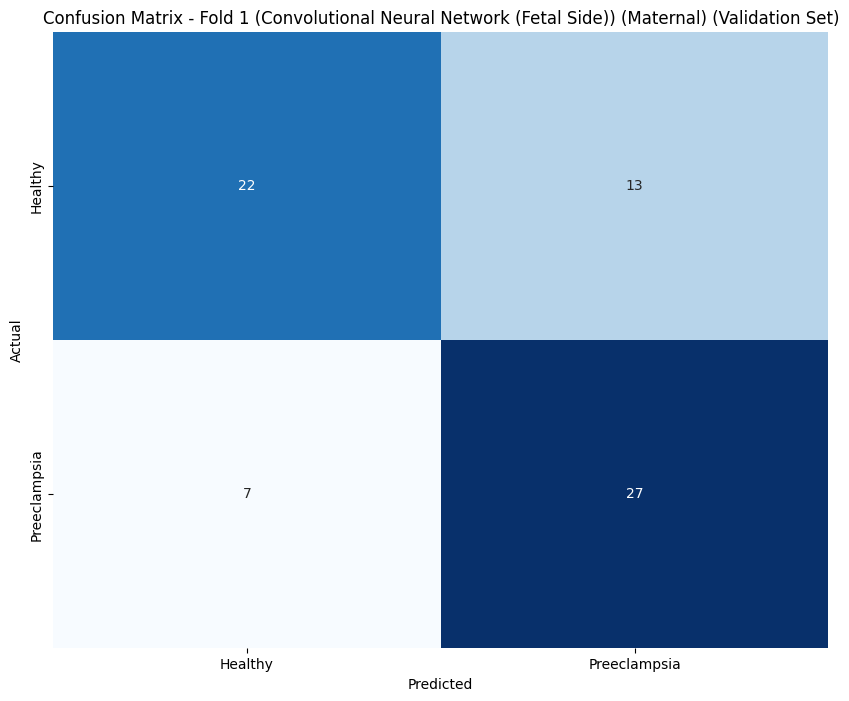


Training Fold 2


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.7585       0.5072      0.0000        0.7133             0.0000          0.0000           0.6706     +  0.0010  98.2568


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      2        0.6760       0.5362      0.6596        0.6879             0.5167          0.9118           0.6840     +  0.0010  95.3225
      3        0.6378       0.6957      0.6557        0.6363             0.7407          0.5882           0.7319     +  0.0010  98.0934
      4        0.6140       0.6087      0.6747        0.6308             0.5714          0.8235           0.7479        0.0010  97.7557
      5        0.5697       0.7391      0.7353        0.5949             0.7353          0.7353           0.7714     +  0.0010  96.2295
      6        0.5461       0.6522      0.7000        0.6007             0.6087          0.8235           0.7790        0.0008  94.2631
      7        0.5248       0.6812      0.6944        0.5722             0.6579          0.7353           0.7891        0.0008  93.8215
      8        0.4990       0.6812      0.7105        0.5734             0.6429          0.7941           0.7975        0.0008  99.4267
      9        0.5226       0.6957      0.7042  

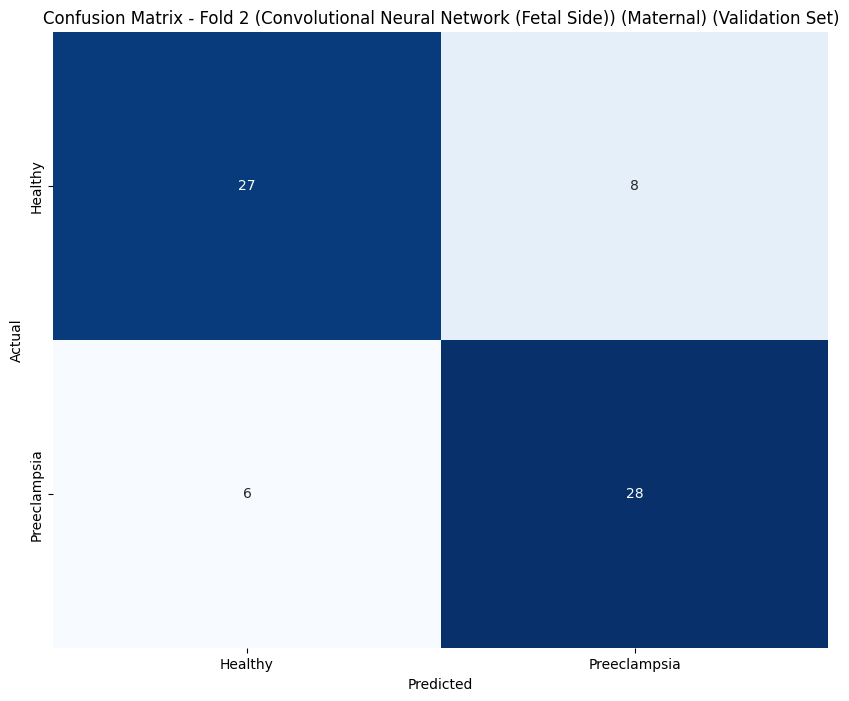


Training Fold 3


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.7058       0.5217      0.6526        0.7178             0.5167          0.8857           0.5353     +  0.0010  99.5697
      2        0.6614       0.5362      0.6863        0.7192             0.5224          1.0000           0.6387     +  0.0010  91.4722
      3        0.6267       0.6087      0.4906        0.6296             0.7222          0.3714           0.7437     +  0.0010  98.0841
      4        0.5803       0.7101      0.7561        0.6136             0.6596          0.8857           0.7597     +  0.0010  95.4791
      5        0.5569       0.6957      0.6866        0.5790             0.7188          0.6571           0.7832        0.0010  94.6017
      6        0.5263       0.7391      0.7692  

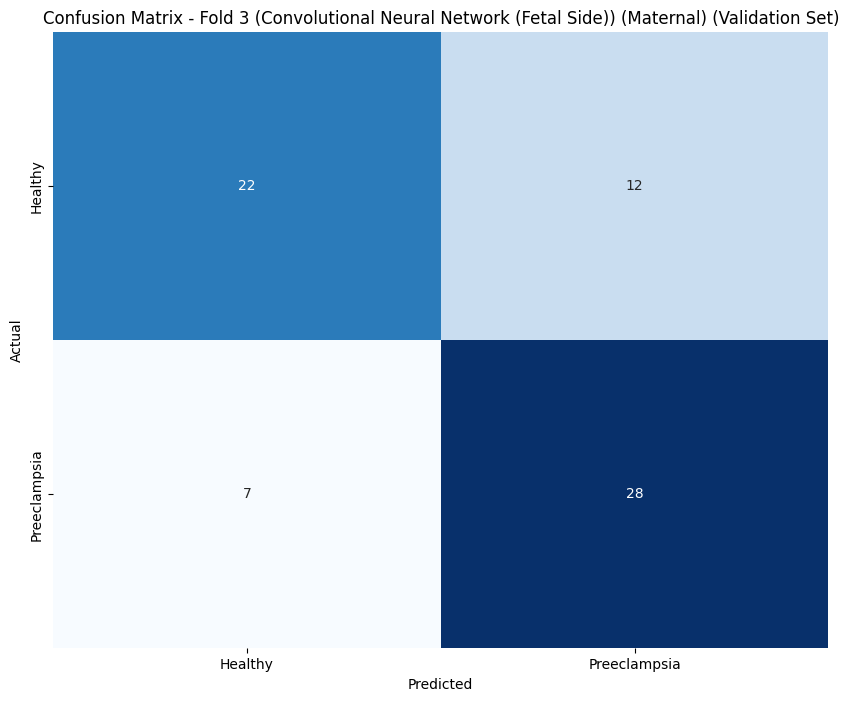


Training Fold 4


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.8087       0.4928      0.0000        0.7326             0.0000          0.0000           0.5261     +  0.0010  98.7028


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


      2        0.7129       0.5217      0.6733        0.7000             0.5152          0.9714           0.5563     +  0.0010  98.2053
      3        0.6455       0.6087      0.4706        0.6640             0.7500          0.3429           0.6681     +  0.0010  101.2434
      4        0.6179       0.6087      0.6966        0.6492             0.5741          0.8857           0.7076        0.0010  116.4169
      5        0.5853       0.6667      0.5965        0.6214             0.7727          0.4857           0.7664     +  0.0010  126.6421
      6        0.5604       0.6667      0.7229        0.6113             0.6250          0.8571           0.7798        0.0008  118.5418
      7        0.5534       0.6812      0.6667        0.5896             0.7097          0.6286           0.7882     +  0.0008  109.5773
      8        0.5324       0.6812      0.6857        0.5783             0.6857          0.6857           0.8017        0.0008  114.0988
      9        0.5232       0.6812      0.

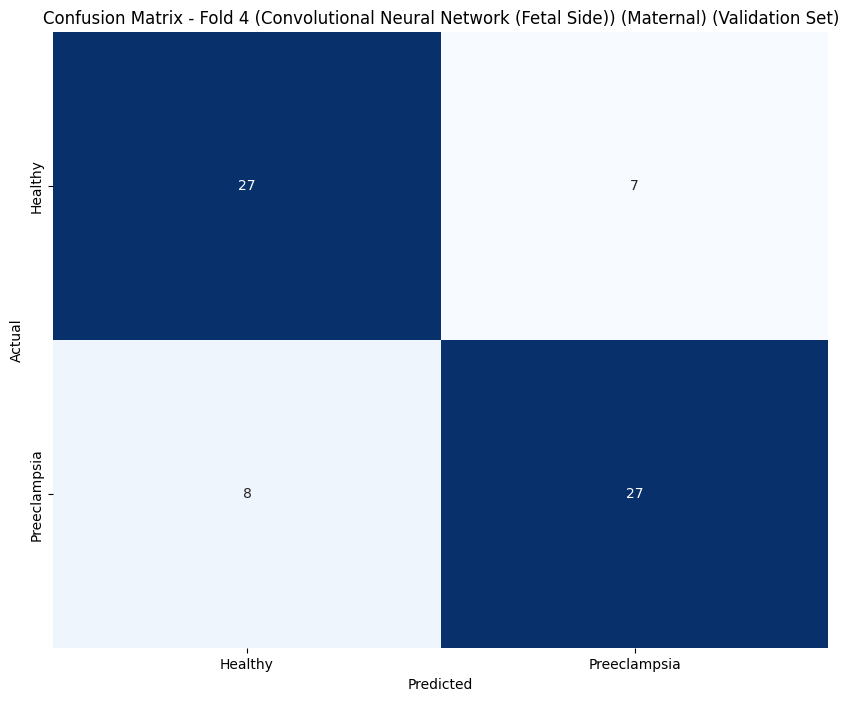


Training Fold 5


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr       dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  --------
      1        0.7042       0.5072      0.0556        0.6921             1.0000          0.0286           0.7513     +  0.0010  120.0904
      2        0.6322       0.6957      0.6667        0.6070             0.7500          0.6000           0.8126     +  0.0010  120.8056
      3        0.5933       0.7681      0.8049        0.5801             0.7021          0.9429           0.8420     +  0.0010  120.0828
      4        0.5583       0.6812      0.5926        0.5796             0.8421          0.4571           0.8378        0.0010  196.2245
      5        0.5246       0.7826      0.8000        0.5464             0.7500          0.8571           0.8504     +  0.0010  152.5098
      6        0.4896       0.7536      0

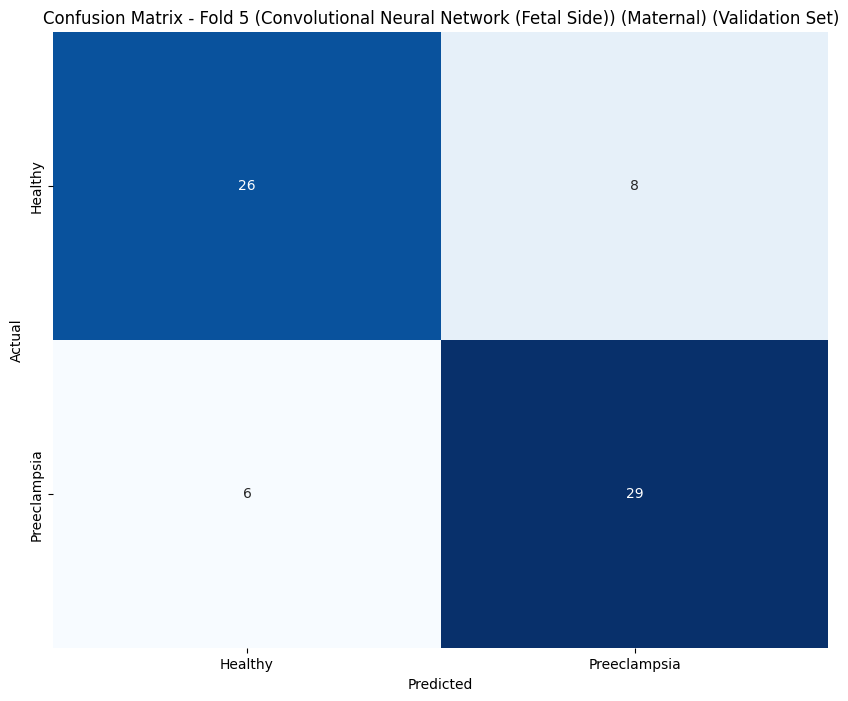

In [13]:
# Assigning the image paths and labels to variables
X = data.path
y = data.label

# Create an empty list to store the performance metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
auc_roc_scores = []

# List to store trained models
trained_models = []  

# Instantiate StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS, shuffle=True, random_state=NEURAL_NETWORK_CONFIG.SEED)

class_names = ['Healthy', 'Preeclampsia'] # Define class names


# File name for storing metrics
csv_file = f'{NAME_OF_EXPERIMENT}_performance_metrics_per_fold_on_validation_data.csv'

# Initialize a list to store metrics for each fold
metrics_per_fold = []

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
    print("")
    print(f'Training Fold {fold + 1}')
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Instantiate PyTorch train and validation sets for the current fold
    TRAIN = Dataset(X_train, y_train, TRANSFORMATIONS.TRAIN_TRANSFORMS)
    VAL = Dataset(X_val, y_val, TRANSFORMATIONS.VAL_TRANSFORMS)
    
    # Configure the filename for the checkpoint based on the fold
    checkpoint_filename = f'{NAME_OF_EXPERIMENT}_fold_{fold + 1}_best_model.pt'
    
    # Create the Checkpoint callback for the current fold
    CHECKPOINT_CALLBACK = Checkpoint(
        f_params=checkpoint_filename,
        monitor='valid_acc_best',
        f_history=f'{NAME_OF_EXPERIMENT}_fold_{fold + 1}_history.csv',
        f_optimizer=f'{NAME_OF_EXPERIMENT}_fold_{fold + 1}_optimizer.pt',
        f_criterion=f'{NAME_OF_EXPERIMENT}_fold_{fold + 1}_criterion.pt',
        f_history_epoch=f'{NAME_OF_EXPERIMENT}_fold_{fold + 1}_history_epoch.csv',
        f_history_batch=f'{NAME_OF_EXPERIMENT}_fold_{fold + 1}_history_batch.csv',
        f_history_batch_epoch=f'{NAME_OF_EXPERIMENT}_fold_{fold + 1}_history_batch_epoch.csv')

    # Update the CALLBACKS list for the current fold
    NEURAL_NETWORK_CONFIG.CALLBACKS = [NEURAL_NETWORK_CONFIG.LRSCHEDULER, CHECKPOINT_CALLBACK, NEURAL_NETWORK_CONFIG.FREEZER, NEURAL_NETWORK_CONFIG.ROC_AUC, NEURAL_NETWORK_CONFIG.RECALL, NEURAL_NETWORK_CONFIG.PRECISION, NEURAL_NETWORK_CONFIG.F1, NEURAL_NETWORK_CONFIG.EARLY_STOPPING]

    # Instantiate Model for the current fold
    model = NeuralNetClassifier(
        Model,
        criterion=NEURAL_NETWORK_CONFIG.CRITERION,
        lr=NEURAL_NETWORK_CONFIG.LR,
        batch_size=NEURAL_NETWORK_CONFIG.BATCH_SIZE,
        max_epochs=NEURAL_NETWORK_CONFIG.EPOCHS,
        module__output_features=NEURAL_NETWORK_CONFIG.OUTPUT_FEATURES,  
        optimizer= NEURAL_NETWORK_CONFIG.OPTIMIZER,
        train_split=predefined_split(VAL),
        callbacks=NEURAL_NETWORK_CONFIG.CALLBACKS,
        device=NEURAL_NETWORK_CONFIG.DEVICE
    )

    # Train the model for the current fold
    
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context
    
    model.fit(TRAIN, y=None)

    # Get validation accuracy for the current fold
    y_pred_val = model.predict(VAL)

        
    acc_val = accuracy_score(y_val, y_pred_val)
    precision_val = precision_score(y_val, y_pred_val, average=NEURAL_NETWORK_CONFIG.PRECISION_AVERAGE_PARAMETER)  
    recall_val = recall_score(y_val, y_pred_val, average=NEURAL_NETWORK_CONFIG.RECALL_AVERAGE_PARAMETER)  
    f1_val = f1_score(y_val, y_pred_val, average=NEURAL_NETWORK_CONFIG.F1_AVERAGE_PARAMETER) 
    
    y_prob_val = model.predict_proba(VAL)[:, 1]  
    auc_roc_val = roc_auc_score(y_val, y_prob_val, average=NEURAL_NETWORK_CONFIG.ROC_AUC_AVERAGE_PARAMETER) 
    
    # Display the validation performance metrics for the current fold
    print(f'Validation Accuracy for Fold {fold + 1} -> {acc_val}')
    print(f'Validation Precision for Fold {fold + 1} -> {precision_val}')
    print(f'Validation Recall for Fold {fold + 1} -> {recall_val}')
    print(f'Validation F1 Score for Fold {fold + 1} -> {f1_val}')
    print(f'Validation AUC-ROC Score for Fold {fold + 1} -> {auc_roc_val}')
    
    # Append metrics to the list
    metrics_per_fold.append({
        'Model_Name': NAME_OF_EXPERIMENT,
        'Fold': fold + 1,
        'Accuracy': acc_val,
        'Precision': precision_val,
        'Recall': recall_val,
        'F1 Score': f1_val,
        'AUC-ROC Score': auc_roc_val
    })
    
    # Write metrics to a CSV file
    with open(csv_file, mode='w', newline='') as file:
        fieldnames = ['Model_Name', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC Score']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        writer.writeheader()
        for fold_metrics in metrics_per_fold:
            writer.writerow(fold_metrics)
            
    print(f"Metrics for each fold saved to {csv_file}")

    # Store the performance metrics
    accuracies.append(acc_val)
    precisions.append(precision_val)
    recalls.append(recall_val)
    f1_scores.append(f1_val)
    auc_roc_scores.append(auc_roc_val)    
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred_val)
    print(conf_matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Fold {fold + 1} ({NAME_OF_EXPERIMENT}) (Maternal) (Validation Set)')

    # Save the plot to your directory
    plt.savefig(f'{NAME_OF_EXPERIMENT}_confusion_matrix_fold_{fold + 1}_valid.png')

    # Show the plot
    plt.show()
        


# Evaluation of model

In [14]:
# Calculating the average validation performance metrics across all folds
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1 = np.mean(f1_scores)
average_auc_roc = np.mean(auc_roc_scores)

# Displaying the average validation performance metrics across all folds
print(f'Average Validation Accuracy across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_accuracy}')
print(f'Average Validation Precision across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_precision}')
print(f'Average Validation Recall across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_recall}')
print(f'Average Validation F1 Score across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_f1}')
print(f'Average Validation AUC ROC Score across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_auc_roc}')


# Creating a dataframe that contains the average validation performance metrics
average_performance_metrics = pd.DataFrame({
    'Model_Name': [NAME_OF_EXPERIMENT],
    'Number of Folds': [NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS],
    'Average Validation Accuracy': [average_accuracy],
    'Average Validation Precision': [average_precision],
    'Average Validation Recall': [average_recall],
    'Average Validation F1 Score': [average_f1],
    'Average Validation AUC-ROC': [average_auc_roc]
})

# Save the dataframe that contains the average validation performance metrics to CSV
average_performance_metrics.to_csv(f'{NAME_OF_EXPERIMENT}_average_validation_performance_metrics.csv', index=False)


Average Validation Accuracy across 5 Folds -> 0.7623188405797101
Average Validation Precision across 5 Folds -> 0.7650891512321091
Average Validation Recall across 5 Folds -> 0.7623188405797101
Average Validation F1 Score across 5 Folds -> 0.7615336717958201
Average Validation AUC ROC Score across 5 Folds -> 0.8536134453781512


# Evaluating on test data

Re-initializing module because the following parameters were re-set: output_features.


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Re-initializing criterion.
Re-initializing optimizer.
[[16  4]
 [ 2 17]]


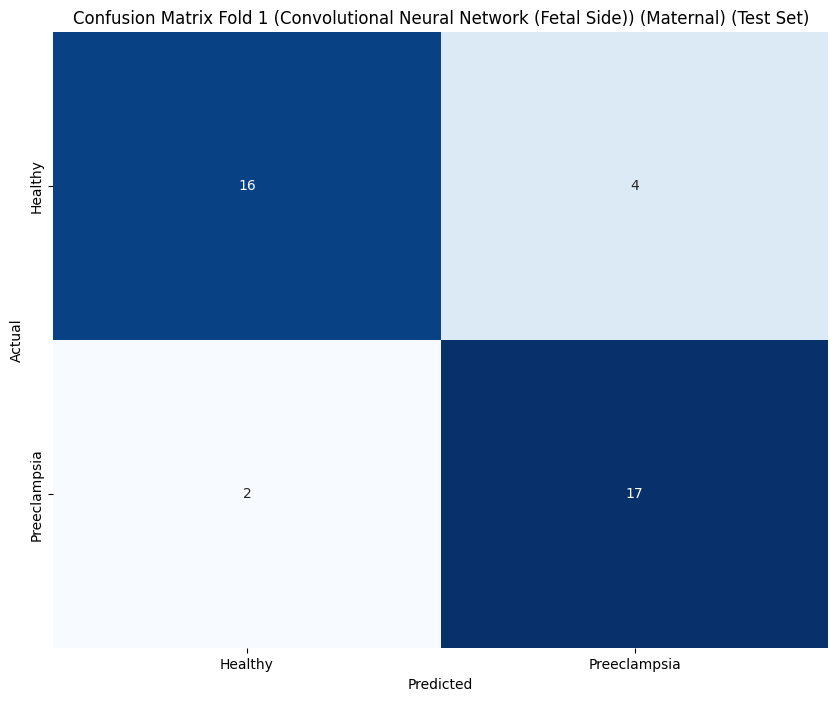

0.8461538461538461
0.8502238502238502
0.8461538461538461
0.8459514170040486
0.9421052631578948
Metrics for each fold saved to Convolutional Neural Network (Fetal Side)_performance_metrics_per_fold_on_test_data.csv
Re-initializing module because the following parameters were re-set: output_features.


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Re-initializing criterion.
Re-initializing optimizer.
[[17  3]
 [ 2 17]]


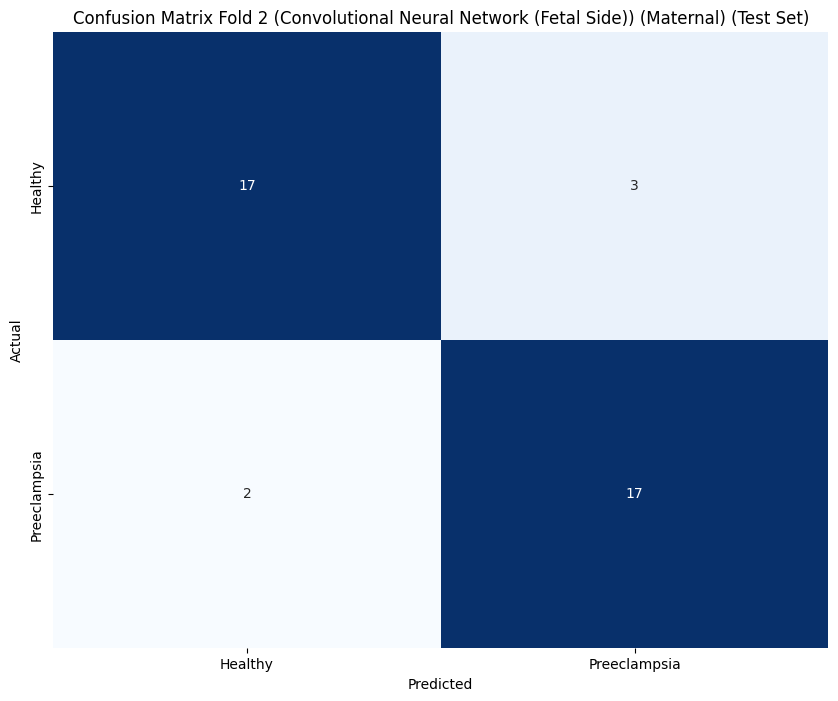

0.8717948717948718
0.8729419703103914
0.8717948717948718
0.8717948717948718
0.9210526315789473
Metrics for each fold saved to Convolutional Neural Network (Fetal Side)_performance_metrics_per_fold_on_test_data.csv
Re-initializing module because the following parameters were re-set: output_features.


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Re-initializing criterion.
Re-initializing optimizer.
[[17  3]
 [ 2 17]]


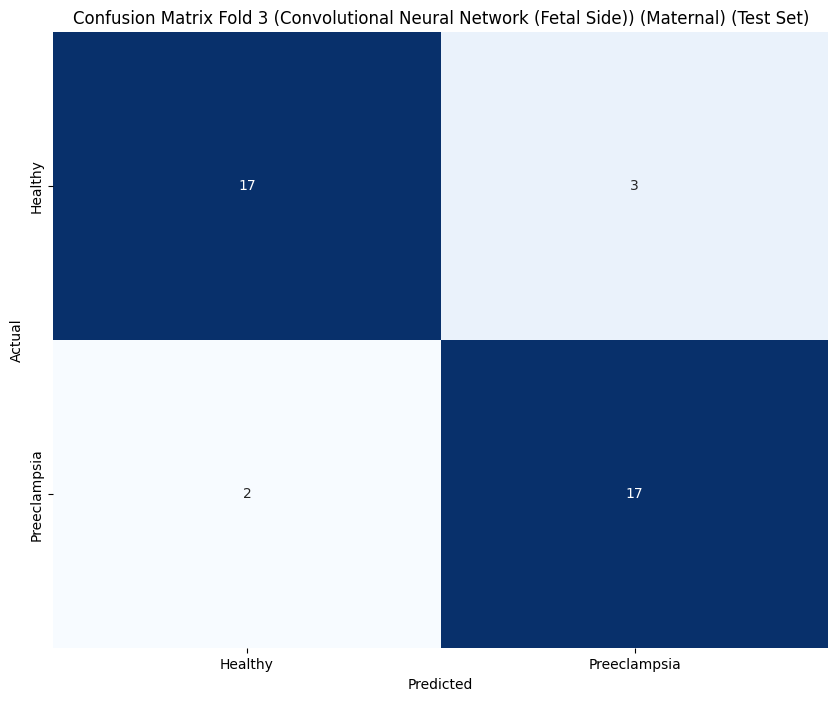

0.8717948717948718
0.8729419703103914
0.8717948717948718
0.8717948717948718
0.9131578947368422
Metrics for each fold saved to Convolutional Neural Network (Fetal Side)_performance_metrics_per_fold_on_test_data.csv
Re-initializing module because the following parameters were re-set: output_features.


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Re-initializing criterion.
Re-initializing optimizer.
[[18  2]
 [ 2 17]]


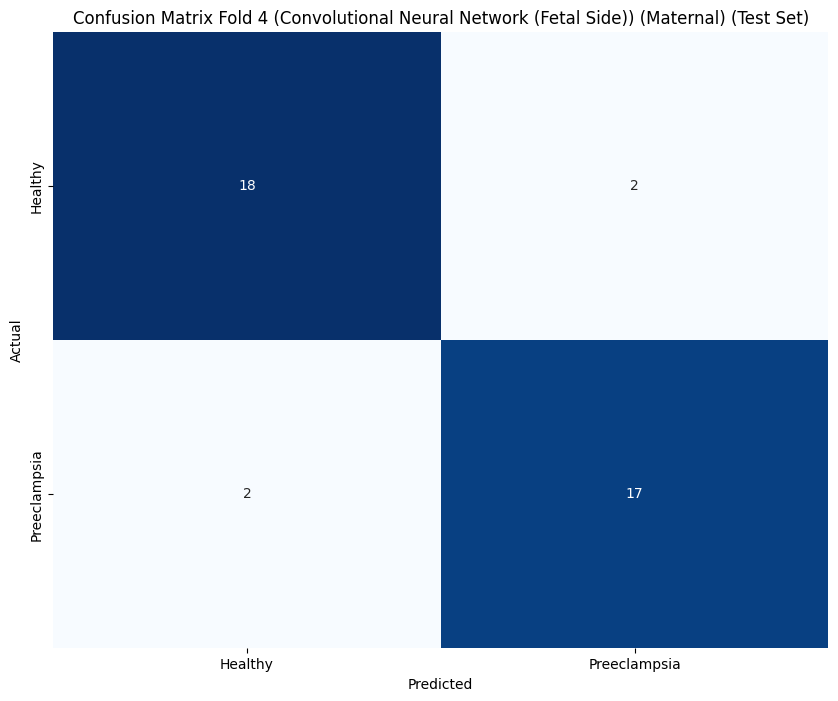

0.8974358974358975
0.8974358974358975
0.8974358974358975
0.8974358974358975
0.9526315789473685
Metrics for each fold saved to Convolutional Neural Network (Fetal Side)_performance_metrics_per_fold_on_test_data.csv
Re-initializing module because the following parameters were re-set: output_features.


/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adamtaback/Desktop/Professional/Dr._Brian_Cox_2023_Summer/EbenezerProject/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Re-initializing criterion.
Re-initializing optimizer.
[[17  3]
 [ 3 16]]


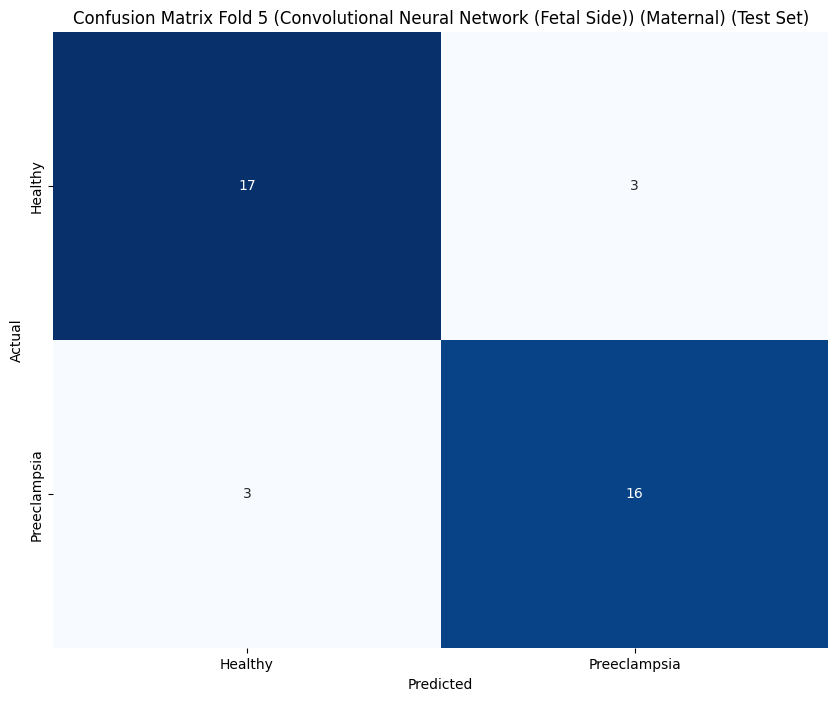

0.8461538461538461
0.8461538461538461
0.8461538461538461
0.8461538461538461
0.9421052631578948
Metrics for each fold saved to Convolutional Neural Network (Fetal Side)_performance_metrics_per_fold_on_test_data.csv


In [15]:
# Loading test data
X_test = external_test_data.drop("label", axis=1)
y_test = external_test_data["label"]
TEST = Dataset(X_test, y_test, TRANSFORMATIONS.TEST_TRANSFORMS)

class_names = ['Healthy', 'Preeclampsia'] # Define class names

# Initialize lists to store metrics for each fold
accuracy_tests = []
precision_tests = []
recall_tests = []
f1_tests = []
auc_roc_tests = []

# File name for storing metrics
csv_file = f'{NAME_OF_EXPERIMENT}_performance_metrics_per_fold_on_test_data.csv'

# Initialize a list to store metrics for each fold
metrics_per_fold = []

# Iterate over each fold
for fold in range(NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS):
    # Load the checkpoint to make predictions
    model.initialize()  # Initializing the model before loading the parameters
    model.load_params(f_params=f'{NAME_OF_EXPERIMENT}_fold_{fold + 1}_best_model.pt')

    # Now you can make predictions on test data
    y_pred_test = model.predict(TEST)

    # Performance metrics on test data
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test, average=NEURAL_NETWORK_CONFIG.PRECISION_AVERAGE_PARAMETER)  
    recall_test = recall_score(y_test, y_pred_test, average=NEURAL_NETWORK_CONFIG.RECALL_AVERAGE_PARAMETER)  
    f1_test = f1_score(y_test, y_pred_test, average=NEURAL_NETWORK_CONFIG.F1_AVERAGE_PARAMETER) 
    y_prob_test = model.predict_proba(TEST)[:, 1]  
    auc_roc_test = roc_auc_score(y_test, y_prob_test, average=NEURAL_NETWORK_CONFIG.ROC_AUC_AVERAGE_PARAMETER) 
    
    # Append metrics to lists
    accuracy_tests.append(accuracy_test)
    precision_tests.append(precision_test)
    recall_tests.append(recall_test)
    f1_tests.append(f1_test)
    auc_roc_tests.append(auc_roc_test)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    print(conf_matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix Fold {fold + 1} ({NAME_OF_EXPERIMENT}) (Maternal) (Test Set)')

    # Save the plot to your directory
    plt.savefig(f'{NAME_OF_EXPERIMENT}_confusion_matrix_fold_{fold + 1}_test.png')

    # Show the plot
    plt.show()
    
    # print metrics for each fold
    print(accuracy_test)
    print(precision_test)
    print(recall_test)
    print(f1_test)
    print(auc_roc_test)
    
    # Append metrics to the list
    metrics_per_fold.append({
        'Model_Name': NAME_OF_EXPERIMENT,
        'Fold': fold + 1,
        'Accuracy': accuracy_test,
        'Precision': precision_test,
        'Recall': recall_test,
        'F1 Score': f1_test,
        'AUC-ROC Score': auc_roc_test
    })

    
    # Write metrics to a CSV file
    with open(csv_file, mode='w', newline='') as file:
        fieldnames = ['Model_Name', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC Score']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        writer.writeheader()
        for fold_metrics in metrics_per_fold:
            writer.writerow(fold_metrics)
            
    print(f"Metrics for each fold saved to {csv_file}")
    

